In [437]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [438]:
train = pd.read_csv('train.csv')
train = train.drop(['Cabin','Name','Ticket','PassengerId'],axis=1)
train['Age'] = train['Age'].fillna(train['Age'].mean())
train['Embarked'] = train['Embarked'].fillna('S')
train = train.replace('male',0)
train = train.replace('female',1)
train = train.replace('S',0)
train = train.replace('C',1)
train = train.replace('Q',2)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 55.8 KB


In [439]:
test = pd.read_csv('test.csv')
test= test.drop(['Cabin','Name','Ticket'],axis=1)
test['Age'] = test['Age'].fillna(test['Age'].mean())
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())
test = test .replace(['male','female'],[0,1])
test = test.replace(['S','C','Q'],[0,1,2])
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int64  
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Fare         418 non-null    float64
 7   Embarked     418 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 26.2 KB


In [440]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.x = df.drop(columns=['Survived']).values
        self.y = pd.get_dummies(df['Survived']).values
        pass

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x=torch.FloatTensor(self.x[idx])
        y=torch.FloatTensor(self.y[idx])
        return x,y


train = MyDataset(df=train)
train

In [441]:
class MyDataset2(torch.utils.data.Dataset):
    def __init__(self, df):
        self.x = df.drop('PassengerId',axis=1).values
        self.y = df['PassengerId']
        pass

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x=torch.FloatTensor(self.x[idx])
        y=(self.y[idx])
        return x, y


test = MyDataset2(df=test)
test

In [442]:
train= torch.utils.data.DataLoader(train,batch_size=1024)
test = torch.utils.data.DataLoader(test)
train

In [443]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(7, 7),
            torch.nn.ReLU(),
            torch.nn.Linear(7, 7),
            torch.nn.ReLU(),
            torch.nn.Linear(7, 2)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using mps device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=7, bias=True)
    (1): ReLU()
    (2): Linear(in_features=7, out_features=7, bias=True)
    (3): ReLU()
    (4): Linear(in_features=7, out_features=2, bias=True)
  )
)


In [444]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters())

In [445]:
def trainAI(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    totalLoss=0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        totalLoss +=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return totalLoss

Epoch 1
-------------------------------
loss: 0.937777  [  891/  891]
Epoch 2
-------------------------------
loss: 0.925616  [  891/  891]
Epoch 3
-------------------------------
loss: 0.914076  [  891/  891]
Epoch 4
-------------------------------
loss: 0.903103  [  891/  891]
Epoch 5
-------------------------------
loss: 0.892650  [  891/  891]
Epoch 6
-------------------------------
loss: 0.882712  [  891/  891]
Epoch 7
-------------------------------
loss: 0.873235  [  891/  891]
Epoch 8
-------------------------------
loss: 0.864218  [  891/  891]
Epoch 9
-------------------------------
loss: 0.855687  [  891/  891]
Epoch 10
-------------------------------
loss: 0.847508  [  891/  891]
Epoch 11
-------------------------------
loss: 0.839689  [  891/  891]
Epoch 12
-------------------------------
loss: 0.832228  [  891/  891]
Epoch 13
-------------------------------
loss: 0.825147  [  891/  891]
Epoch 14
-------------------------------
loss: 0.818373  [  891/  891]
Epoch 15
------

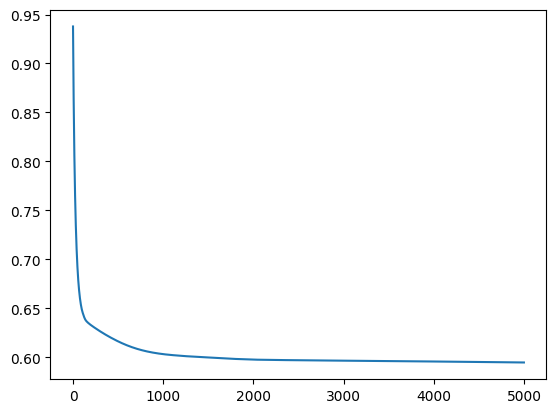

In [446]:
epochs = 5000 
totalLoss=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    totalLoss.append(trainAI(train, model, loss_fn, optimizer))
print("Done!")

plt.plot(totalLoss)

In [447]:
def testAI(dataloader, model, loss_fn):
    model.eval()
    out = []
    with torch.no_grad():
        for X ,y  in dataloader:
            X  = X.to(device)
            pred = model(X)
            out.append([y.item(), torch.argmax(pred).item()])
    return out
result = testAI(test, model, loss_fn)
result

[[892, 0],
 [893, 0],
 [894, 0],
 [895, 0],
 [896, 0],
 [897, 0],
 [898, 0],
 [899, 1],
 [900, 0],
 [901, 0],
 [902, 0],
 [903, 0],
 [904, 1],
 [905, 0],
 [906, 1],
 [907, 1],
 [908, 0],
 [909, 0],
 [910, 0],
 [911, 0],
 [912, 1],
 [913, 0],
 [914, 1],
 [915, 1],
 [916, 1],
 [917, 0],
 [918, 1],
 [919, 0],
 [920, 0],
 [921, 0],
 [922, 0],
 [923, 1],
 [924, 0],
 [925, 0],
 [926, 1],
 [927, 0],
 [928, 0],
 [929, 0],
 [930, 0],
 [931, 1],
 [932, 0],
 [933, 0],
 [934, 0],
 [935, 0],
 [936, 1],
 [937, 0],
 [938, 0],
 [939, 0],
 [940, 1],
 [941, 0],
 [942, 1],
 [943, 0],
 [944, 1],
 [945, 1],
 [946, 0],
 [947, 1],
 [948, 0],
 [949, 0],
 [950, 0],
 [951, 1],
 [952, 0],
 [953, 0],
 [954, 0],
 [955, 0],
 [956, 1],
 [957, 0],
 [958, 0],
 [959, 0],
 [960, 0],
 [961, 1],
 [962, 0],
 [963, 0],
 [964, 0],
 [965, 1],
 [966, 1],
 [967, 1],
 [968, 0],
 [969, 0],
 [970, 0],
 [971, 0],
 [972, 0],
 [973, 1],
 [974, 0],
 [975, 0],
 [976, 0],
 [977, 0],
 [978, 0],
 [979, 0],
 [980, 0],
 [981, 0],
 [982, 0],

In [452]:
result = pd.DataFrame(result)
result = result.astype(int)
result.columns=['passengerId','Survived']
result

,passengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [453]:
result.to_csv('result.csv',index=False)